In [39]:
import numpy as np

from collections import OrderedDict
import matplotlib.pyplot as plt
import seaborn as sn

%matplotlib inline

## Funciones

Distribuciones para inicializar los pesos. Son generadores que se inicializan con los parámetros de la distribución, devuelven la distribución que debe aceptar como argumento una tupla con la forma `(filas, columnas)`.

In [40]:
def distribución_uniforme(menor=-.5, mayor=.5):
    return lambda forma: np.random.uniform(low=menor, high=mayor, size=forma)

Funciones de costo para calcular el error.

In [41]:
def error_cuadrático(objetivo, predicción):
    return np.sum( (objetivo - predicción)**2 ) / 2

Funciones de activación con sus derivadas. Son generadores que se inicializan con los parámetros de la función, devuelven la función y su derivada, ambas deben aceptar como argumento un arreglo de Numpy.

In [42]:
def escalón():
    f = lambda x: np.piecewise(x, [x < 0, x >= 0], [0, 1])
    d = lambda x: 1
    
    return f, d


def identidad():
    f = lambda x: x
    d = lambda x: 1
    
    return f, d


def logística():
    f = lambda x: 1 / (1 + np.exp(-x))
    d = lambda x: f(x) * (1 - f(x))

    return f, d


def tanh():
    f = np.tanh
    d = lambda x: 1 - f(x)**2
    
    return f, d

## Elementos de la red

Una **capa** se define en base a cierta cantidad de unidades con una función de activación.

En la **propagación** el parámetro `i` representa el valor de entrada a las unidades y el parámetro `o`, el de salida. Cabe notar que a la salida se le agrega el bias de la capa. El bias es _virtual_, no está representado como unidad.

```
    entrada    función activación    salida
                                     | o0 | = 1 (BIAS)
    | i1 |                           | o1 |
    | i2 | --> f(i) ---------------> | o2 |
    | i3 |                           | o3 |
```

Cuando consideramos la **retropropagación** del error, el sentido inverso utiliza los parámetros `ei` y `eo` para los errores que entran a y salen de la capa, respectivamente.

```
    salida     derivada activación   entrada
                                     | ei0 | = 1 (BIAS)
    | eo1 |                          | ei1 |
    | eo2 | <- f'(i) · ei <--------- | ei2 |
    | eo3 |                          | ei3 |
```

In [60]:
class Capa:
    
    def __init__(self, activación, unidades):
        self.función, self.derivada = activación()
        self.unidades = unidades
        self.feeds = []
        self.backs = []
        
        
    def propagar(self):
        Y = self.función(self.i)
        self.o = np.insert(Y, 0, 1., axis=1) # agregar vector columna de bias
        
        for sinapsis in self.feeds: sinapsis.propagar()

            
    def retropropagar(self, eta):
        E = np.delete(self.ei, 0, axis=1) # remover vector columna de bias
        self.eo = E * self.derivada(self.i)
        
        for sinapsis in self.backs: sinapsis.retropropagar(eta)
        
        
    def estado(self):
        return np.delete(self.o, 0, axis=1) # remover vector columna de bias
    
    
    def error(self, E):
        self.ei = np.insert(E, 0, 1., axis=1) # agregar vector columna de bias

Las capas se comunican mediante **sinapsis**. Una sinapsis tiene una capa de _origen_ y una de _destino_, a su vez guarda los pesos de las conexiones entre unidades.

Los elementos de la red están pensados para tratar a las muestas como *vectores filas*. En un arreglo bidimensional de varias muestras, cada fila es una muestra y las columnas del arreglo son los distintos atributos. En la bibliografía se suele observar otro camino: las muestras son *vectores columnas*; quizás sea más sencillo para hacer/interpretar cuentas. En la práctica, encontramos a los vectores filas más a tono con la forma de los conjuntos de datos (pensar en un archivo CSV o en una tabla de una base de datos).

```
    filas    = dim(origen) + 1 (BIAS)
    columnas = dim(destino)
    
    W =  | b00  b01 |  matriz de pesos de una sinapsis que conecta una capa de 3 unidades (origen) con otra de 2 (destino)
         | w10  w11 |  la primera fila corresponde a los pesos del bias
         | w20  w21 |
         | w30  w31 |
         
    Y =  | 1  a1  a2  a3 |  actividad de salida de la capa de origen, 2 muestras con 3 atributos y bias (primera columna)
         | 1  b1  b2  b3 |
         
    Z =  Y · W =  | a'1  a'2 |  la actividad de entrada a la capa de destino entonces se calcula
                  | b'1  b'2 |  como el producto interno entre la salida (Y) y los pesos (W)
```

In [61]:
class Sinapsis:
  
    def __init__(self, origen, destino, inicialización):
        self.origen  = origen
        self.destino = destino
        self.inicialización = inicialización
        self.forma   = (origen.unidades + 1, destino.unidades)      
        
        
    def inicializar(self):
        self.W = self.inicialización(self.forma)
        
        
    def propagar(self):
        Y = self.origen.o # actividad de la capa anterior
        self.destino.i = np.dot(Y, self.W)
        
    
    def retropropagar(self, eta):
        E = self.destino.eo # error de la capa posterior        
        self.origen.ei = np.dot(E, self.W.T)
        self.ajustar_pesos(eta)
        
          
    def ajustar_pesos(self, eta):
        Y = self.origen.o # actividad de la capa anterior
        E = self.destino.eo # error de la capa posterior
        
        self.W += eta * np.dot(Y.T, E)

Las siguientes funciones se utilizan durante el entrenamiento.

In [72]:
def lotes(X, y, n):
    for i in range(0, len(X), n):
        yield X[i:i+n], y[i:i+n]

        
def barajar(X, y):
    e = np.random.get_state()
    X = np.random.permutation(X)
    np.random.set_state(e)
    y = np.random.permutation(y)
    
    return X, y


def graficar(evolución_error):
    plt.plot(evolución_error)
    plt.xlabel('épocas')
    plt.ylabel('error')

In [79]:
class Red:

    def __init__(self, *capas, conexiones=None, inicialización=distribución_uniforme()):
        self.capas    = OrderedDict()
        self.sinapsis = OrderedDict()
        
        # instanciación de capas
        for (id, activación, unidades) in capas:
            self.capas[id] = Capa(activación, unidades)        
            
        # instanciación de sinapsis
        for (id_origen, id_destino, inicialización) in conexiones or self.__conexiones_defecto__(inicialización):
            origen   = self.capas[id_origen]
            destino  = self.capas[id_destino]
            
            sinapsis = self.sinapsis[(id_origen, id_destino)] = Sinapsis(origen, destino, inicialización)
            
            origen.feeds.append(sinapsis)
            destino.backs.append(sinapsis)
            
            
    def __conexiones_defecto__(self, inicialización):
        id_capas = list(self.capas.keys())
        
        for id_origen, id_destino in zip(id_capas, id_capas[1:]):
            yield id_origen, id_destino, inicialización

            
    def entrenar(self, X, y, eta=0.7, épocas=1000, tamaño_lote=1, tolerancia=1e-3, costo=error_cuadrático):
        for sinapsis in self.sinapsis.values(): sinapsis.inicializar()
        
        self.evolución_error = []
        
        for época in range(épocas):
            _X, _y = barajar(X, y)
            
            y_pred = np.concatenate(
                [self.__aprender__(lote_X, lote_y, eta) for lote_X, lote_y in lotes(_X, _y, tamaño_lote)]
            )
            
            error = costo(_y, y_pred)
            self.evolución_error.append(error)
            
            if error <= tolerancia: return self
       
        print('NO CONVERGE')
            
            
    def __aprender__(self, X, y_obj, eta):
        y_pred = self.predecir(X)
        
        self.capas['salida'].error(y_obj - y_pred) 
        
        for _, capa in reversed(self.capas.items()): capa.retropropagar(eta)
        
        return y_pred
        
    
    def predecir(self, X):
        self.capas['entrada'].i = X
        
        for _, capa in self.capas.items(): capa.propagar()
        
        return self.capas['salida'].estado()

## Pruebas

In [66]:
X = np.array([[1, 1],
              [1, 0],
              [0, 1],
              [0, 0]])

y = np.array([[1, 1, 0],
              [0, 1, 1],
              [0, 1, 1],
              [0, 0, 0]])

In [67]:
rn = Red( ('entrada', identidad, 2), ('oculta', logística, 2), ('salida', escalón, 3) )

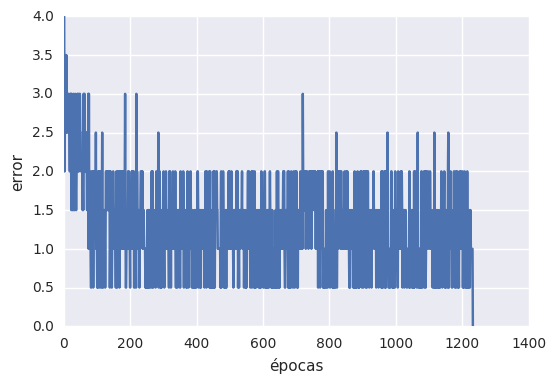

In [80]:
rn.entrenar(X, y, épocas=10000)

graficar(rn.evolución_error)